## Imports

In [1]:
import os
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
import missingno as msno
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
pd.set_option('display.max_columns', None)
from sktime.forecasting.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import seaborn as sns
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX as StatsmodelsSARIMAX
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from prophet import Prophet

In [2]:
#surpress warnings

warnings.filterwarnings("ignore")

## Load data

In [3]:
def load_data(path):
    df = pd.read_csv(path, parse_dates=['datetime'])
    df = df.sort_index()
    columns_to_drop = ['Unnamed: 0', 'sunrise', 'sunset']
    df = df.drop(columns=columns_to_drop)
    df['datetime'] = pd.to_datetime(df['datetime'])

    last_year = df['datetime'].max() - pd.DateOffset(years=1)
    df_last_year = df[df['datetime'] >= last_year]
    df = df.sort_values('datetime')
    
    return df, df_last_year


In [4]:
df_london, df_last_year_london = load_data(r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\data\london_weather_2014-2024.csv')
df_manila, df_last_year_manila = load_data(r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\data\manila_weather_2014-2024.csv')


In [5]:
df_london.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,conditions,description,icon,stations
0,"London, England, United Kingdom",2014-01-01,11.6,6.7,9.1,11.6,3.6,7.0,6.7,84.8,11.857,100,16.67,rain,0.0,0.0,72.4,38.4,190.5,993.1,67.4,14.2,6.9,0.5,0,NaN,0.00,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"03769099999,EGWU,03680099999,03768399999,03672..."
1,"London, England, United Kingdom",2014-01-02,11.0,6.6,9.1,11.0,3.6,7.2,6.0,81.0,5.394,100,12.50,rain,0.0,0.0,51.8,29.8,216.2,993.4,47.4,26.7,38.3,3.3,2,NaN,0.03,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"03769099999,03680099999,03672099999,0378109999..."
2,"London, England, United Kingdom",2014-01-03,10.6,7.3,9.0,10.6,3.2,6.5,5.1,76.8,6.030,100,16.67,rain,0.0,0.0,77.4,33.5,218.4,994.5,52.8,17.9,30.3,2.8,2,NaN,0.07,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"03769099999,03680099999,03672099999,0378109999..."
3,"London, England, United Kingdom",2014-01-04,10.1,4.5,8.0,10.1,2.0,5.1,5.2,82.4,5.239,100,16.67,rain,0.0,0.0,62.1,29.2,206.0,993.6,67.6,22.0,17.4,1.4,1,NaN,0.10,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"03769099999,03680099999,03672099999,0378109999..."
4,"London, England, United Kingdom",2014-01-05,12.0,1.8,6.0,12.0,-0.9,3.6,3.9,85.9,0.201,100,8.33,rain,0.0,0.0,55.6,30.4,192.5,1000.0,66.5,25.5,30.4,2.6,2,NaN,0.14,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"03769099999,03680099999,03672099999,0378109999..."


## Testing for stationarity of the data

As this is a time series comparative study, there is a need to understand the if the data is stationary. 

- https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/
- https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322?gi=334565268e20

In [6]:
def test_stationarity(df):
    result = adfuller(df)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] < 0.05:
        print('TS is stationary')
    else:
        print('TS not stationary')

In [7]:
test_stationarity(df_manila['temp'])

ADF Statistic: -6.139003242410702
p-value: 8.0561165344187e-08
TS is stationary


In [8]:
# data is stationary therefore it will not be needing differantiation

## Descriptive statistics and EDA

In [9]:
def descriptive_stats(df):
    print("shape: ", df.shape)
    print("column headers: ", df.columns)
    print("first date in series: ", df_london['datetime'].min())
    print("last date in series: ", df_london['datetime'].max())
    print("minimum temperature: ", df_london['temp'].min())
    print("maximum temperature: ", df_london['temp'].max())
    print("missing data: ", df_london.isna().sum())
    print("descriptive statistics: ", df_london.describe())
    print("df info: ", df_london.info())
    print("number of missing values per column: ", df_london.isnull().sum())
    

In [10]:
descriptive_stats(df_london)

shape:  (3793, 31)
column headers:  Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase',
       'conditions', 'description', 'icon', 'stations'],
      dtype='object')
first date in series:  2014-01-01 00:00:00
last date in series:  2024-05-20 00:00:00
minimum temperature:  -3.2
maximum temperature:  30.3
missing data:  name                   0
datetime               0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype          1426
sno

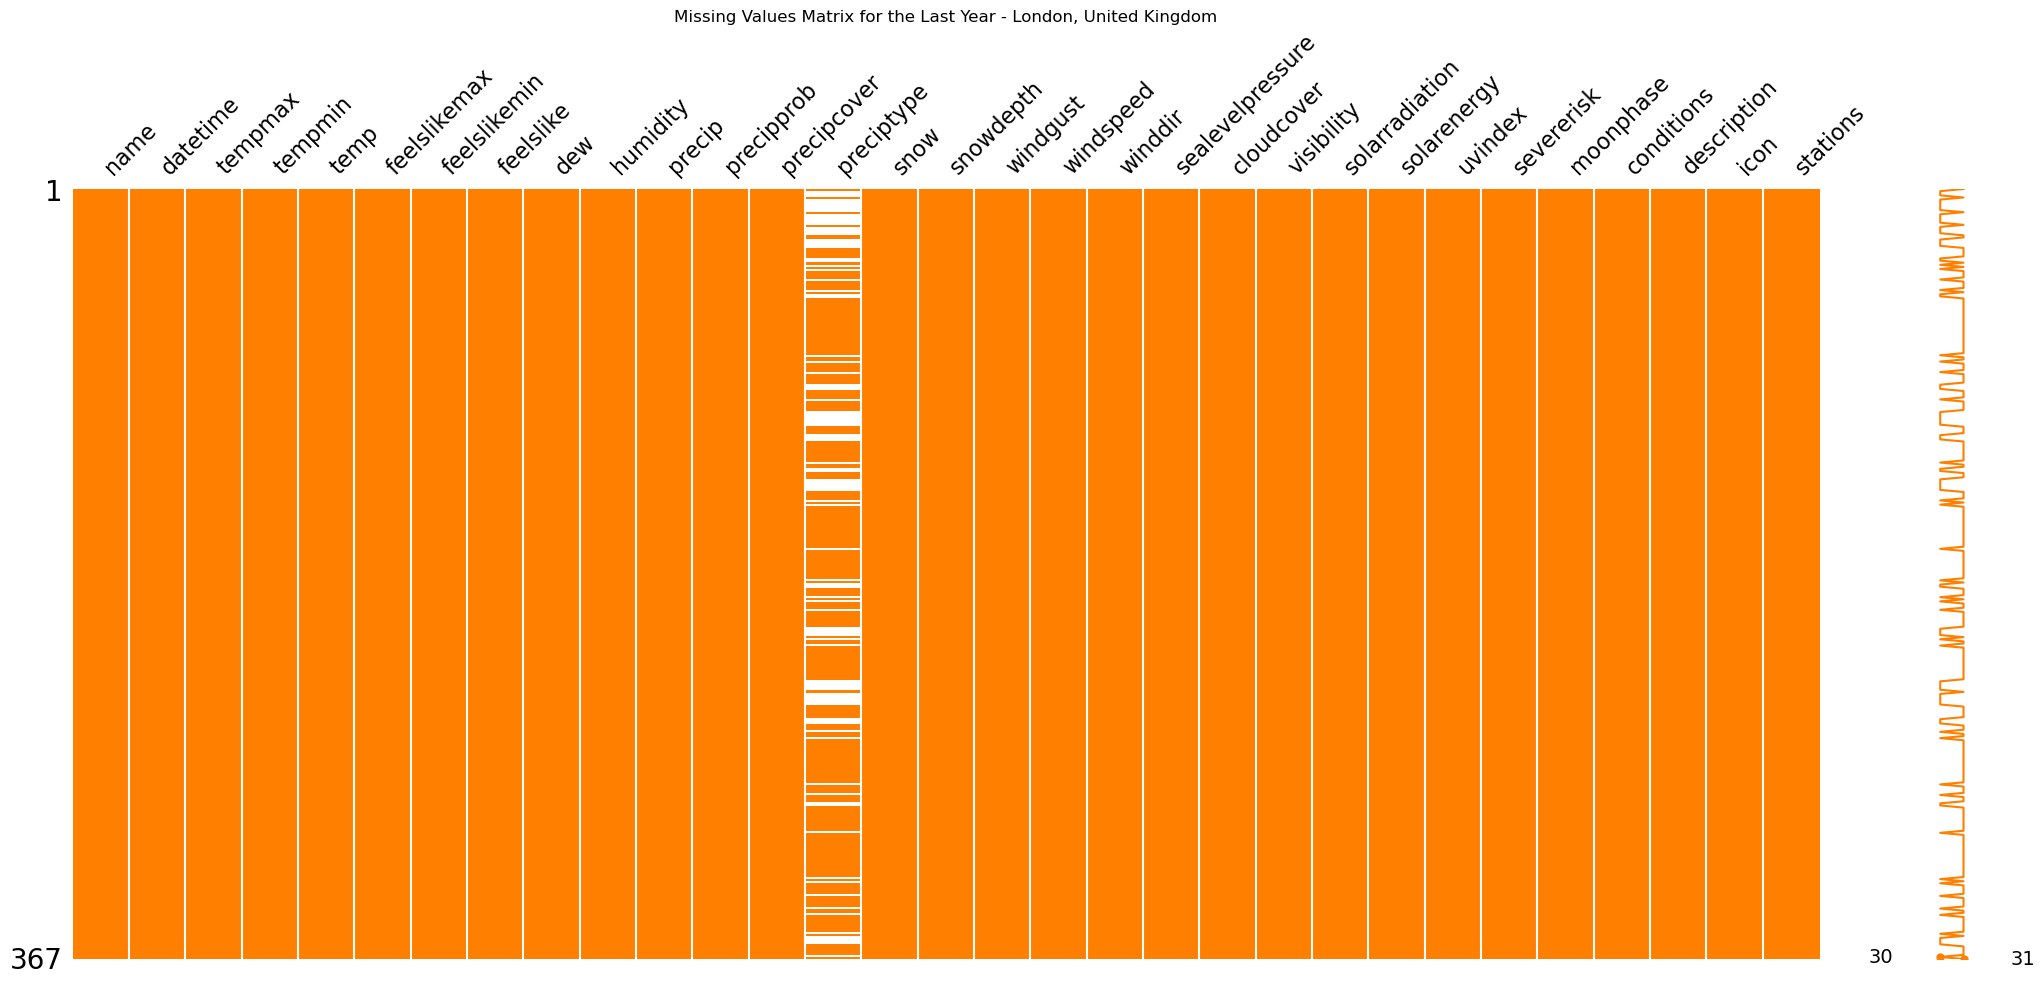

In [11]:
#checking for missing values

msno.matrix(df_last_year_london, color=(1.0, 0.5, 0.0))
plt.title('Missing Values Matrix for the Last Year - London, United Kingdom')
plt.show()

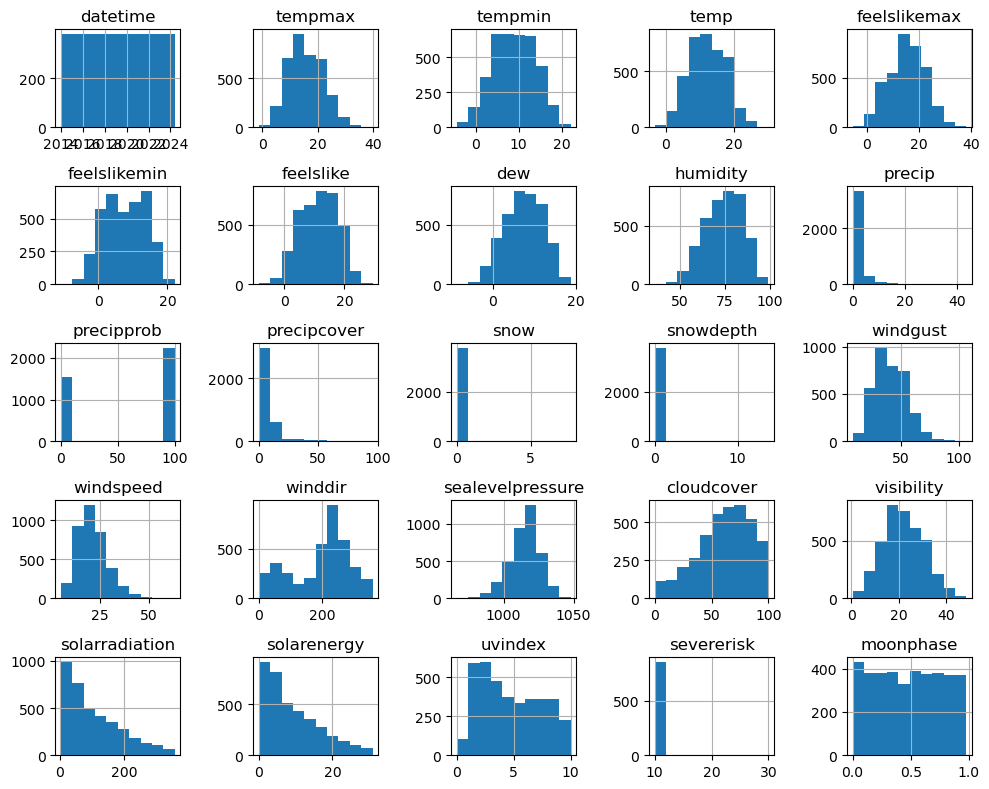

In [12]:
#checking data distribution

df_london.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

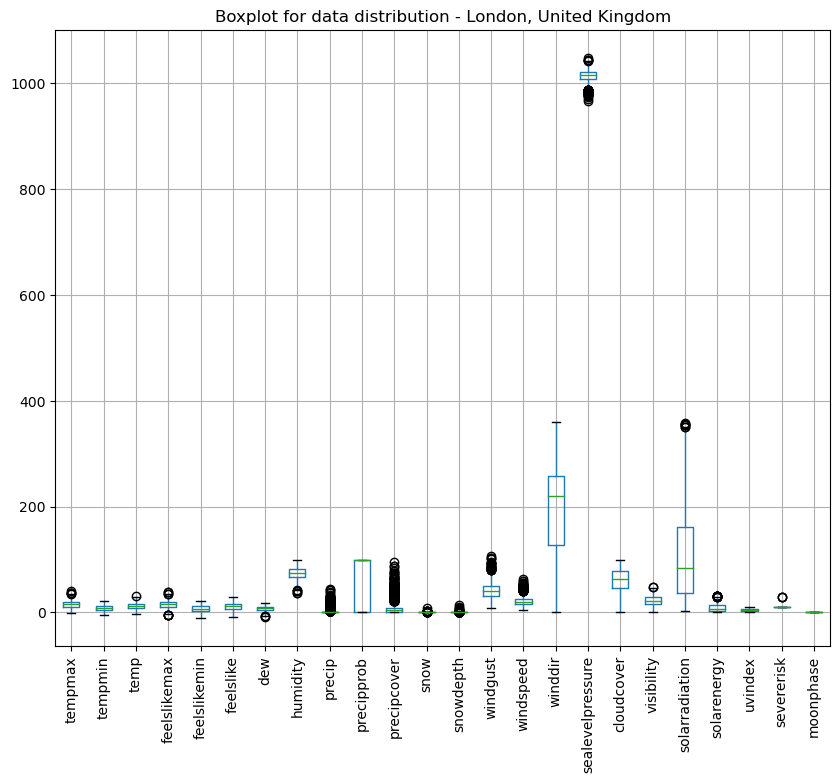

In [13]:
#data distribution
df_london.boxplot(figsize=(10, 8))
plt.xticks(rotation=90)
plt.title('Boxplot for data distribution - London, United Kingdom')
plt.show()

In [14]:
#creating the correlation between features, for feature importane later on and heatmap
df_london_for_corr = df_london.drop(['name', 'preciptype', 'conditions','description','icon', 'stations'],axis=1)

In [15]:
df_london_for_corr.head()

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
0,2014-01-01,11.6,6.7,9.1,11.6,3.6,7.0,6.7,84.8,11.857,100,16.67,0.0,0.0,72.4,38.4,190.5,993.1,67.4,14.2,6.9,0.5,0,NaN,0.00
1,2014-01-02,11.0,6.6,9.1,11.0,3.6,7.2,6.0,81.0,5.394,100,12.50,0.0,0.0,51.8,29.8,216.2,993.4,47.4,26.7,38.3,3.3,2,NaN,0.03
2,2014-01-03,10.6,7.3,9.0,10.6,3.2,6.5,5.1,76.8,6.030,100,16.67,0.0,0.0,77.4,33.5,218.4,994.5,52.8,17.9,30.3,2.8,2,NaN,0.07
3,2014-01-04,10.1,4.5,8.0,10.1,2.0,5.1,5.2,82.4,5.239,100,16.67,0.0,0.0,62.1,29.2,206.0,993.6,67.6,22.0,17.4,1.4,1,NaN,0.10
4,2014-01-05,12.0,1.8,6.0,12.0,-0.9,3.6,3.9,85.9,0.201,100,8.33,0.0,0.0,55.6,30.4,192.5,1000.0,66.5,25.5,30.4,2.6,2,NaN,0.14


In [16]:
corr_matrix = df_london_for_corr.corr()
print(corr_matrix) 

                  datetime   tempmax   tempmin      temp  feelslikemax  \
datetime          1.000000  0.008865  0.010205  0.007740      0.012812   
tempmax           0.008865  1.000000  0.880739  0.973772      0.992570   
tempmin           0.010205  0.880739  1.000000  0.956810      0.882454   
temp              0.007740  0.973772  0.956810  1.000000      0.970469   
feelslikemax      0.012812  0.992570  0.882454  0.970469      1.000000   
feelslikemin      0.010829  0.892497  0.984158  0.957931      0.897502   
feelslike         0.011530  0.966945  0.950490  0.992946      0.972603   
dew               0.025422  0.815229  0.919002  0.888771      0.826023   
humidity          0.047910 -0.510786 -0.295188 -0.433604     -0.484854   
precip            0.019130 -0.079772  0.028707 -0.037742     -0.072548   
precipprob       -0.058845 -0.235622 -0.062457 -0.167136     -0.222448   
precipcover       0.236525 -0.163003 -0.025887 -0.107080     -0.148046   
snow              0.007829 -0.115714 -

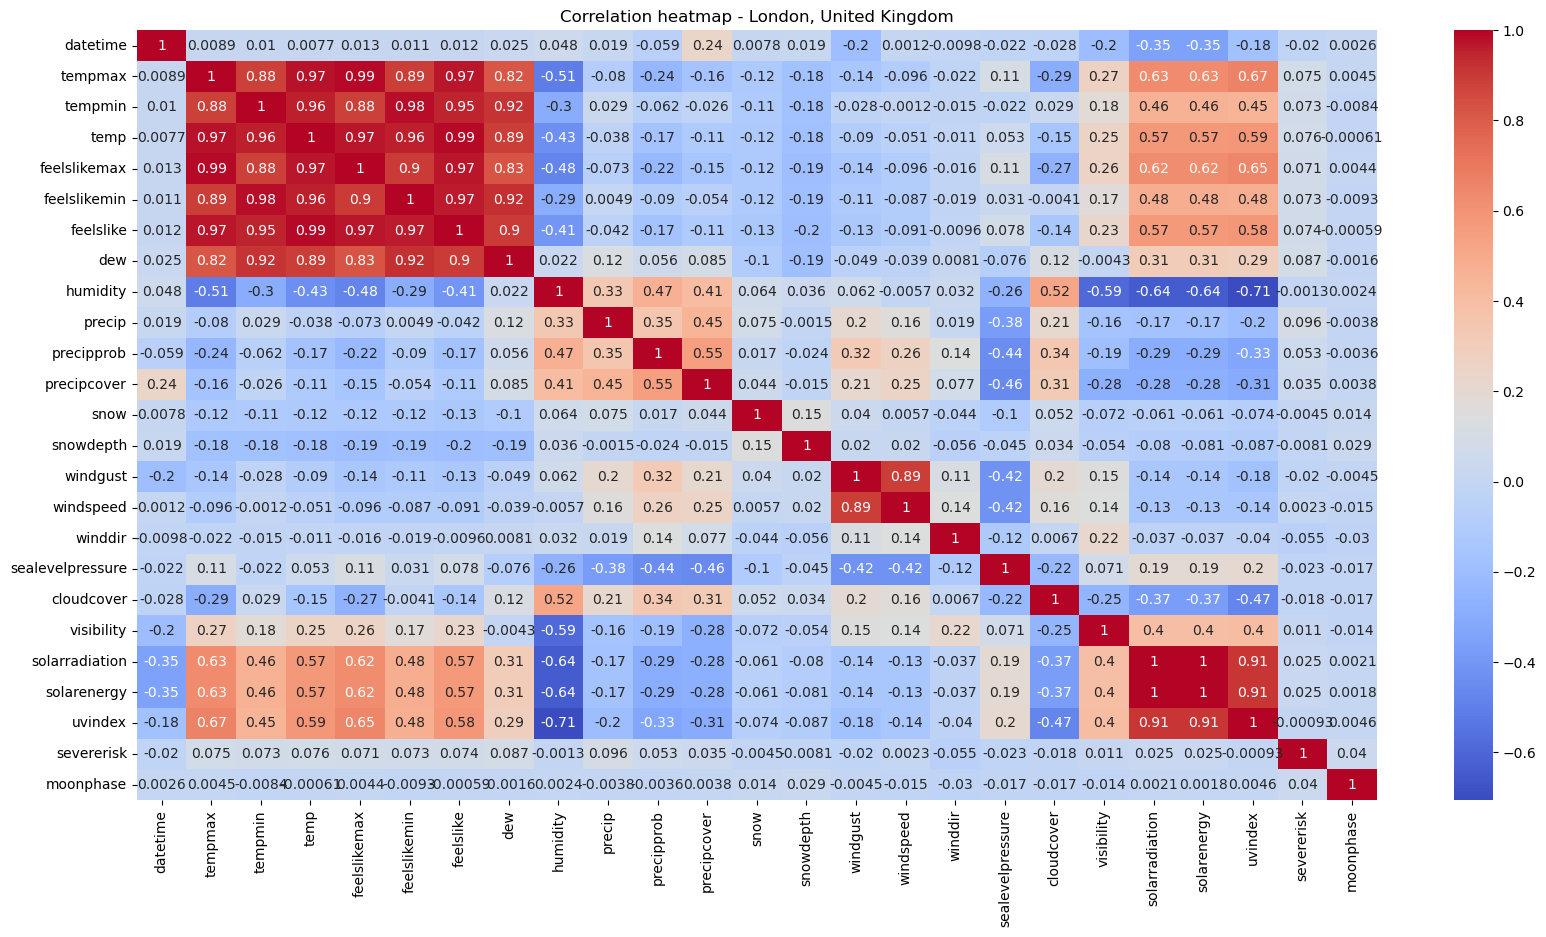

In [17]:
#heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation heatmap - London, United Kingdom")
plt.show()

look into the correlation that humidity has with temp (-0.43) + solarradiation, solarenergy or uvindex
look into multicolinearity - multiple feature that are roughly the same as the target, which need to be removed (first 5 after the first one)

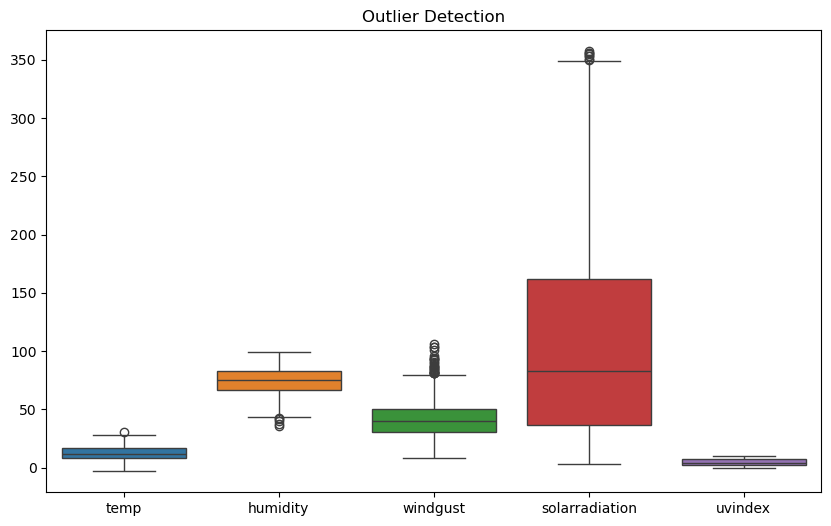

In [18]:
#checking for outliers

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_london[['temp', 'humidity', 'windgust', 'solarradiation', 'uvindex']])
plt.title("Outlier Detection")
plt.show()

In [19]:
# look into how each of these are measured 
# for example temp is the average at 18 
#first run the models with outliers and then see the results 

In [20]:
df_london.set_index("datetime", inplace = True)
df_london.sort_index(inplace = True)

In [21]:
df_london.head()

,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,conditions,description,icon,stations
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,"London, England, United Kingdom",11.6,6.7,9.1,11.6,3.6,7.0,6.7,84.8,11.857,100,16.67,rain,0.0,0.0,72.4,38.4,190.5,993.1,67.4,14.2,6.9,0.5,0,NaN,0.00,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"03769099999,EGWU,03680099999,03768399999,03672..."
2014-01-02,"London, England, United Kingdom",11.0,6.6,9.1,11.0,3.6,7.2,6.0,81.0,5.394,100,12.50,rain,0.0,0.0,51.8,29.8,216.2,993.4,47.4,26.7,38.3,3.3,2,NaN,0.03,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"03769099999,03680099999,03672099999,0378109999..."
2014-01-03,"London, England, United Kingdom",10.6,7.3,9.0,10.6,3.2,6.5,5.1,76.8,6.030,100,16.67,rain,0.0,0.0,77.4,33.5,218.4,994.5,52.8,17.9,30.3,2.8,2,NaN,0.07,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"03769099999,03680099999,03672099999,0378109999..."
2014-01-04,"London, England, United Kingdom",10.1,4.5,8.0,10.1,2.0,5.1,5.2,82.4,5.239,100,16.67,rain,0.0,0.0,62.1,29.2,206.0,993.6,67.6,22.0,17.4,1.4,1,NaN,0.10,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"03769099999,03680099999,03672099999,0378109999..."
2014-01-05,"London, England, United Kingdom",12.0,1.8,6.0,12.0,-0.9,3.6,3.9,85.9,0.201,100,8.33,rain,0.0,0.0,55.6,30.4,192.5,1000.0,66.5,25.5,30.4,2.6,2,NaN,0.14,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"03769099999,03680099999,03672099999,0378109999..."


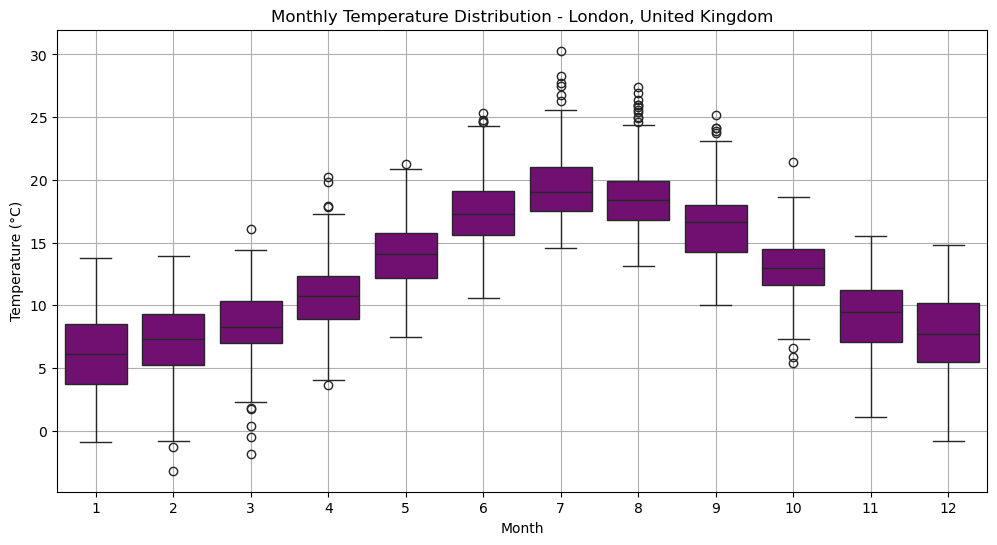

In [22]:
#understanding monthly distribution of the data and how the temperature differ from month to month

df_london['month'] = df_london.index.month

plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='temp', data=df_london, color="purple")
plt.title('Monthly Temperature Distribution - London, United Kingdom')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

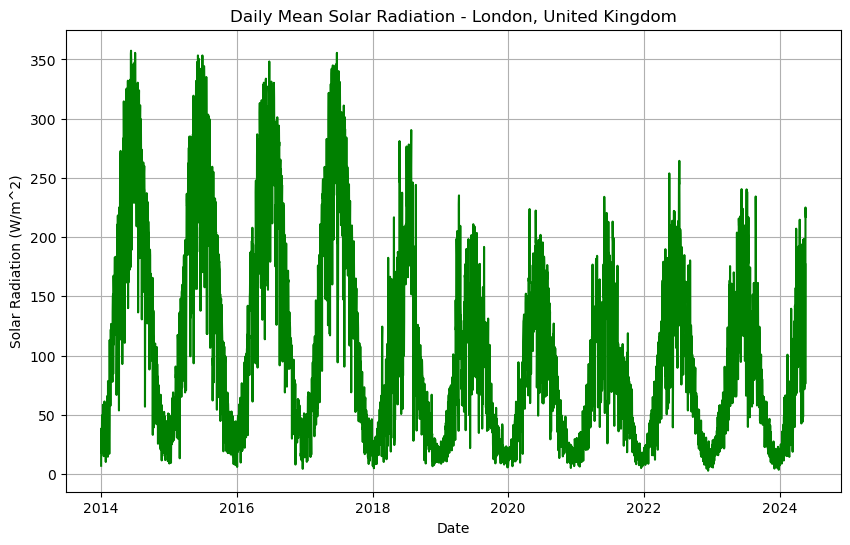

In [23]:
#looking to understand how the mean solar radiation is changing from year to year

daily_solar_radiation = df_london['solarradiation'].resample('D').mean()

plt.figure(figsize=(10, 6))
plt.plot(daily_solar_radiation.index, daily_solar_radiation.values, linestyle='-', color='green')
plt.title('Daily Mean Solar Radiation - London, United Kingdom')
plt.xlabel('Date')
plt.ylabel('Solar Radiation (W/m^2)')
plt.grid(True)
plt.show()

## Missing values

In [24]:
df_london.isna().sum()

name                   0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype          1426
snow                   0
snowdepth              0
windgust             175
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
uvindex                0
severerisk          2931
moonphase              0
conditions             0
description            0
icon                   0
stations               0
month                  0
dtype: int64

In [25]:
#run k-nn to fill in the missing values with the k nearest neighbour 
#https://www.sciencedirect.com/science/article/abs/pii/S0164121212001586#:~:text=kNN%20imputation%20is%20designed%20to,or%20attribute)%20is%20categorical%2C%20referred

imputer = KNNImputer(n_neighbors=5)
df_london[['windgust', 'severerisk']] = imputer.fit_transform(df_london[['windgust', 'severerisk']])

In [26]:
df_london['preciptype'].unique()

array(['rain', nan, 'rain,snow', 'snow'], dtype=object)

In [27]:
df_london['preciptype'].value_counts()

preciptype
rain         2320
rain,snow      40
snow            7
Name: count, dtype: int64

In [28]:
df_london.isna().sum()

name                   0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype          1426
snow                   0
snowdepth              0
windgust               0
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
uvindex                0
severerisk             0
moonphase              0
conditions             0
description            0
icon                   0
stations               0
month                  0
dtype: int64

In [29]:
#filling in missing values from precipitation because if they are missing, it means there was no registration of precipitation that day
df_london['preciptype'] = df_london['preciptype'].fillna(0)

In [30]:
df_london.isna().sum()

name                0
tempmax             0
tempmin             0
temp                0
feelslikemax        0
feelslikemin        0
feelslike           0
dew                 0
humidity            0
precip              0
precipprob          0
precipcover         0
preciptype          0
snow                0
snowdepth           0
windgust            0
windspeed           0
winddir             0
sealevelpressure    0
cloudcover          0
visibility          0
solarradiation      0
solarenergy         0
uvindex             0
severerisk          0
moonphase           0
conditions          0
description         0
icon                0
stations            0
month               0
dtype: int64

## Droppping columns

In [31]:
# based on the heatmap, it seems that columns like tempmax, tempin, feelslikemax, feelslikemin and feelslike are too similar with the target variable and they are being dropped as to not create any data leakage in the models to follow

- https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/

In [32]:
columns_to_drop = ['tempmax', 'tempmin', 'icon', 'stations', 'conditions', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'preciptype', 'name']
df_london = df_london.drop(columns=columns_to_drop)

## Tokenization of the "description" column

1. Converting Text Data into Numerical Form:
Time series models generally work with numerical data. Tokenization converts textual data into a numerical representation (e.g., by using techniques like one-hot encoding, TF-IDF, or embeddings), making it possible to include this information in the model.
2. Handling Categorical Information:
If the string column contains categorical information (e.g., product types, user IDs, etc.), tokenization helps in breaking down these categories into features that can be used by the model. This is particularly useful when lagged versions of these categories can influence future predictions.
3. Capturing Sequential Patterns:
Tokenization can reveal patterns in the string data that might have temporal dependencies. For example, specific terms or categories might influence the target variable over time, and these patterns can be captured by lagged features.
4. Reducing Dimensionality:
Advanced tokenization techniques (e.g., word embeddings) can reduce the dimensionality of textual data while retaining meaningful information. This can lead to better generalization in the model, especially when considering lagged features over time.
5. Enriching Feature Space:
Tokenized features can interact with lagged numerical features, enriching the feature space. For instance, certain tokens might have a delayed effect on the target variable, which can be captured when combined with lagged numerical features.
6. Improving Model Interpretability:
Tokenized features might make it easier to interpret the impact of certain textual data over time, especially when analyzing lagged effects.

In [33]:
# adds columns in dataframe to let model know which conditions are most likely in one location

In [34]:
# step 1: text processing
tokenizer = CountVectorizer()
hashingTF = TfidfTransformer(use_idf=False)
idf = TfidfTransformer(use_idf=True)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)

In [35]:
# pipeline that processes text and then clusters
pipeline = Pipeline(steps=[
    ('tokenizer', tokenizer),
    ('hashingTF', hashingTF),
    ('idf', idf),
    ('kmeans', kmeans)
])

In [36]:
# fitting the model on the "description"column
text_features = pipeline.fit_transform(df_london['description'])

In [37]:
kmeans.labels_
df_london['clusters_description'] = kmeans.labels_

In [38]:
df_london['clusters_description'].value_counts()

clusters_description
0    2309
1    1244
2     240
Name: count, dtype: int64

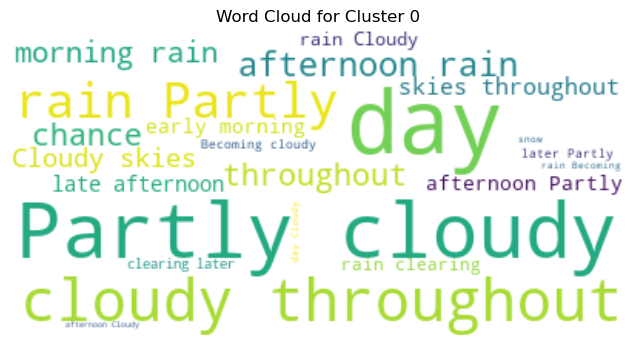

In [39]:
text = ' '.join(description for description in df_london[df_london['clusters_description']==0]['description'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 0')
plt.show()

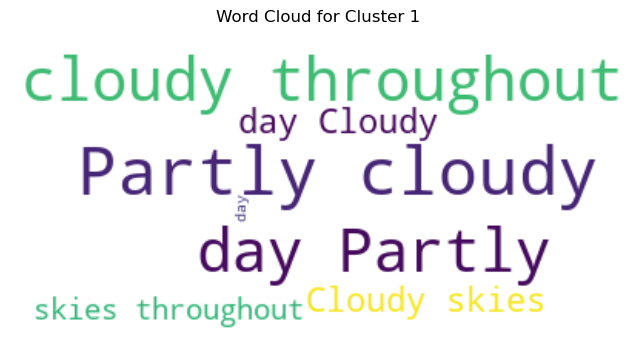

In [40]:
text = ' '.join(description for description in df_london[df_london['clusters_description']==1]['description'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 1')
plt.show()

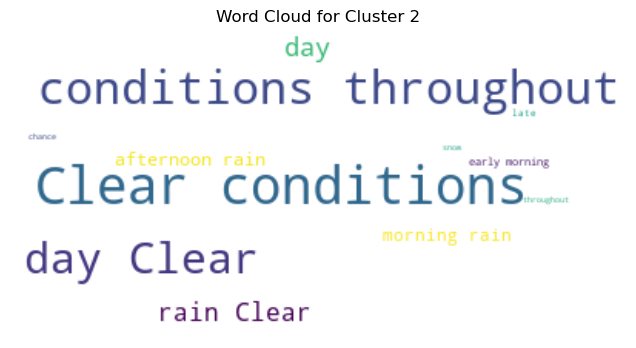

In [41]:
text = ' '.join(description for description in df_london[df_london['clusters_description']==2]['description'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 2')
plt.show()

In [42]:
df_london = df_london.drop(columns=['description'])
df_london.head(20)

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,month,clusters_description
datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-01,9.1,6.7,84.8,11.857,100,16.67,0.0,0.0,72.400000,38.4,190.5,993.1,67.4,14.2,6.9,0.5,0,10.000000,0.00,1,0
2014-01-02,9.1,6.0,81.0,5.394,100,12.50,0.0,0.0,51.800000,29.8,216.2,993.4,47.4,26.7,38.3,3.3,2,10.000000,0.03,1,0
2014-01-03,9.0,5.1,76.8,6.030,100,16.67,0.0,0.0,77.400000,33.5,218.4,994.5,52.8,17.9,30.3,2.8,2,10.000000,0.07,1,0
2014-01-04,8.0,5.2,82.4,5.239,100,16.67,0.0,0.0,62.100000,29.2,206.0,993.6,67.6,22.0,17.4,1.4,1,10.000000,0.10,1,0
2014-01-05,6.0,3.9,85.9,0.201,100,8.33,0.0,0.0,55.600000,30.4,192.5,1000.0,66.5,25.5,30.4,2.6,2,10.000000,0.14,1,0
2014-01-06,11.6,7.6,77.2,11.020,100,16.67,0.0,0.0,65.000000,36.0,219.7,994.6,66.2,14.0,49.6,4.2,2,10.000000,0.17,1,0
2014-01-07,10.7,6.6,75.7,3.628,100,12.50,0.0,0.0,70.600000,35.6,220.3,1003.2,61.9,16.7,22.4,1.9,1,10.000000,0.20,1,0
2014-01-08,9.6,7.0,83.7,1.999,100,4.17,0.0,0.0,51.800000,21.4,204.1,1011.9,69.7,20.8,35.4,3.1,2,10.000000,0.25,1,0
2014-01-09,9.0,4.9,75.9,3.993,100,12.50,0.0,0.0,58.100000,32.6,246.3,1006.4,51.6,31.6,40.7,3.5,2,10.000000,0.27,1,0


## Lagged features

1. Capturing Autocorrelation:
Time series data often exhibit autocorrelation, meaning past values influence future values. Lagged features explicitly capture this relationship by including previous observations as features. For instance, if the target variable at time 
𝑡
t is influenced by its value at time 
𝑡
−
1
t−1, creating a lagged feature for 
𝑡
−
1
t−1 allows the model to recognize this dependency.
2. Modeling Seasonality and Trends:
Time series data can have seasonal patterns or long-term trends. Lagged features at specific intervals (e.g., a lag of 12 months to capture annual seasonality) help the model learn and predict these patterns.
3. Enhancing Predictive Power:
By including past values as features, lagged features enrich the information available to the model. This often leads to more accurate predictions, especially when past behavior strongly influences future outcomes.
4. Capturing Delayed Effects:
Some events or changes might have delayed effects on the target variable. Lagged features allow the model to capture these delays. For example, a marketing campaign might not impact sales immediately but could have a lagged effect over several weeks.
5. Enabling Simple Models to Capture Complex Dynamics:
Even simple models, like linear regression, can capture complex time series dynamics when lagged features are included. For instance, a linear model with appropriately selected lagged features can effectively forecast data that would otherwise require more complex models.
6. Creating Interaction Terms:
Lagged features can interact with other variables, providing additional insights into how past values of the target variable (or other features) influence future outcomes in conjunction with other factors.

In [43]:
#shifting the features by 3 days

In [44]:
# this shifts all features by three days except the temp, and then it merges them back togther
df_london_shifted = df_london.drop('temp', axis=1).shift(3)

In [45]:
df_london_eng = pd.concat([df_london['temp'], df_london_shifted], axis=1)

In [46]:
df_london_eng.head()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,month,clusters_description
datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-01,9.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,9.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,8.0,6.7,84.8,11.857,100.0,16.67,0.0,0.0,72.4,38.4,190.5,993.1,67.4,14.2,6.9,0.5,0.0,10.0,0.00,1.0,0.0
2014-01-05,6.0,6.0,81.0,5.394,100.0,12.50,0.0,0.0,51.8,29.8,216.2,993.4,47.4,26.7,38.3,3.3,2.0,10.0,0.03,1.0,0.0


In [47]:
df_london_shifted.head()

,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,month,clusters_description
datetime,,,,,,,,,,,,,,,,,,,,
2014-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,6.7,84.8,11.857,100.0,16.67,0.0,0.0,72.4,38.4,190.5,993.1,67.4,14.2,6.9,0.5,0.0,10.0,0.00,1.0,0.0
2014-01-05,6.0,81.0,5.394,100.0,12.50,0.0,0.0,51.8,29.8,216.2,993.4,47.4,26.7,38.3,3.3,2.0,10.0,0.03,1.0,0.0


In [48]:
# adding back the last three rows, which have all the shifted features but without the temp for them as that is what we predict
last_three = df_london_shifted.tail(3)
last_three.set_index( pd.date_range(start=max(df_london.index)+pd.Timedelta(days=1), periods=3, freq='D'))


,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,month,clusters_description
2024-05-21,10.5,69.7,0.797,100.0,8.33,0.0,0.0,25.0,15.2,147.1,1004.2,52.3,19.4,118.8,10.3,9.0,10.0,0.25,5.0,0.0
2024-05-22,12.4,89.1,10.126,100.0,20.83,0.0,0.0,18.4,10.1,213.9,1005.2,58.3,15.8,74.5,6.5,3.0,10.0,0.27,5.0,0.0
2024-05-23,10.3,70.2,0.000,0.0,0.00,0.0,0.0,17.4,9.4,194.8,1009.3,41.4,21.7,177.8,15.5,10.0,10.0,0.30,5.0,1.0


In [49]:
max(df_london.index)+pd.Timedelta(days=1)

Timestamp('2024-05-21 00:00:00')

In [50]:
df_london_final = pd.concat([df_london_eng, last_three], ignore_index=True)

In [51]:
df_london_final = df_london_final.set_index(pd.date_range(start=min(df_london.index), periods=len(df_london)+3, freq='D'))

In [52]:
df_london_final.tail()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,month,clusters_description
2024-05-19,16.6,12.4,89.1,10.126,100.0,20.83,0.0,0.0,18.4,10.1,213.9,1005.2,58.3,15.8,74.5,6.5,3.0,10.0,0.27,5.0,0.0
2024-05-20,15.1,10.3,70.2,0.000,0.0,0.00,0.0,0.0,17.4,9.4,194.8,1009.3,41.4,21.7,177.8,15.5,10.0,10.0,0.30,5.0,1.0
2024-05-21,NaN,10.5,69.7,0.797,100.0,8.33,0.0,0.0,25.0,15.2,147.1,1004.2,52.3,19.4,118.8,10.3,9.0,10.0,0.25,5.0,0.0
2024-05-22,NaN,12.4,89.1,10.126,100.0,20.83,0.0,0.0,18.4,10.1,213.9,1005.2,58.3,15.8,74.5,6.5,3.0,10.0,0.27,5.0,0.0
2024-05-23,NaN,10.3,70.2,0.000,0.0,0.00,0.0,0.0,17.4,9.4,194.8,1009.3,41.4,21.7,177.8,15.5,10.0,10.0,0.30,5.0,1.0


In [53]:
# we've created three new dates with all the lagged features aside from temp, which will be predicted in the next section

## Train and test split 

In [54]:
# done based on the date as it's a time series

In [55]:
# because XGBoost is not a time series model (address it as a limitation), i will split the datetime column into days, months and year, so the model can learn which temperature is related to the May month and which temperature is related to the December month, as it learns accross multiple years

In [56]:
df_london_final['month'] = df_london_final.index.month
df_london_final['year'] = df_london_final.index.year

In [57]:
df_dummies = pd.get_dummies(df_london_final['month'], prefix='month')

In [58]:
df_london_final = pd.concat([df_london_final, df_dummies], axis=1)
df_london_final.drop(columns=['month'], inplace=True)

In [59]:
df_london_final.head()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2014-01-01,9.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,True,False,False,False,False,False,False,False,False,False,False,False
2014-01-02,9.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,True,False,False,False,False,False,False,False,False,False,False,False
2014-01-03,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,True,False,False,False,False,False,False,False,False,False,False,False
2014-01-04,8.0,6.7,84.8,11.857,100.0,16.67,0.0,0.0,72.4,38.4,190.5,993.1,67.4,14.2,6.9,0.5,0.0,10.0,0.00,0.0,2014,True,False,False,False,False,False,False,False,False,False,False,False
2014-01-05,6.0,6.0,81.0,5.394,100.0,12.50,0.0,0.0,51.8,29.8,216.2,993.4,47.4,26.7,38.3,3.3,2.0,10.0,0.03,0.0,2014,True,False,False,False,False,False,False,False,False,False,False,False


In [60]:
df_train = df_london_final.iloc[:-368] #training set - takes the last 368 days
df_test = df_london_final.iloc[-368:-3] #test set - takes the last 368 - the last 3 days for preds
df_future =  df_london_final.iloc[-3:] #future dataframe that contains the predictions that we will generate but right now jas just the features

In [61]:
df_train.head()
df_train.dropna(inplace=True)

In [62]:
# apply regressor 
# create the predictions 
# look R2 and other performance metrics, add in MAE

## 1. XGBOOST 

### 1.1 Baseline model

In [63]:
model_baseline = XGBRegressor()
model_baseline.fit(df_train.drop('temp',axis=1), df_train[['temp']])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [64]:
y_pred_base_xg = model_baseline.predict(df_test.drop('temp',axis=1))

In [65]:
y_pred_base_xg

array([14.492051 , 17.870735 , 16.441523 , 14.017682 , 13.3807955,
       18.364727 , 13.875509 , 16.55626  , 13.40738  , 17.022013 ,
       13.096956 , 15.220464 , 18.718847 , 16.462023 , 17.883986 ,
       18.190876 , 18.983713 , 15.292368 , 13.434772 , 16.804014 ,
       17.765388 , 17.663021 , 17.780577 , 18.162876 , 19.35969  ,
       16.947762 , 18.929035 , 15.666152 , 18.354177 , 16.387234 ,
       18.575077 , 16.272154 , 17.615025 , 20.331121 , 17.903595 ,
       20.021744 , 19.140293 , 18.134293 , 19.111702 , 21.45441  ,
       19.583147 , 20.168015 , 18.224314 , 18.75007  , 18.87896  ,
       17.913774 , 16.178864 , 18.172672 , 20.501274 , 21.236399 ,
       20.726442 , 20.156572 , 17.11704  , 16.378408 , 17.71087  ,
       18.798628 , 16.771502 , 17.329672 , 16.65339  , 17.572655 ,
       19.383886 , 20.404385 , 20.10089  , 18.238998 , 17.524273 ,
       17.880363 , 16.556747 , 16.61994  , 17.54138  , 18.602844 ,
       16.800179 , 17.26145  , 17.58127  , 16.794807 , 18.3065

In [66]:
has_na = np.isnan(y_pred_base_xg).any()
print({has_na})

{False}


In [67]:
na_count = np.isnan(y_pred_base_xg).sum()
print({na_count})

{0}


In [68]:
df_test.isna()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2023-05-22,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2023-05-23,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2023-05-24,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2023-05-25,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2023-05-26,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-16,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2024-05-17,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2024-05-18,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2024-05-19,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


### 1.2 Performance metrics for XGBOOST baseline

In [69]:
mae = mean_absolute_error(df_test['temp'], y_pred_base_xg)
mse = mean_squared_error(df_test['temp'], y_pred_base_xg)
rmse = mse ** 0.5
r2 = r2_score(df_test['temp'], y_pred_base_xg)

print(f"Mean Absolute Error (MAE) for XGBoost baseline with all regressors: {mae}")
print(f"Mean Squared Error (MSE) for XGBoost baseline with all regressors: {mse}")
print(f"Root Mean Squared Error (RMSE) for XGBoost baseline with all regressors: {rmse}")
print(f"R-squared (R2) for XGBoost baseline with all regressors: {r2}")

Mean Absolute Error (MAE) for XGBoost baseline with all regressors: 2.3868065674664227
Mean Squared Error (MSE) for XGBoost baseline with all regressors: 8.827414221743139
Root Mean Squared Error (RMSE) for XGBoost baseline with all regressors: 2.971096467929498
R-squared (R2) for XGBoost baseline with all regressors: 0.6797312280993014


In [70]:
# for RMSE: if my prediction is errored I want that to inflate the error - but don't know in which direction
# MAE: it means it's 2.3 degrees away from truth just don't know in which direction 

### 1.3 XGBOOST baseline predictions vs actuals

In [71]:
df_test[['temp']]

,temp
2023-05-22,15.1
2023-05-23,14.0
2023-05-24,15.8
2023-05-25,15.0
2023-05-26,14.2
...,...
2024-05-16,14.2
2024-05-17,16.4
2024-05-18,15.8
2024-05-19,16.6


In [72]:
df_test_w_preds = df_test.copy()

In [73]:
#create new column in order to attach index date to the preds
df_test_w_preds['preds'] = y_pred_base_xg

In [74]:
def plot_forecast(actuals, predictions): 
    plt.figure(figsize=(15, 10))
    plt.plot(actuals, label='Actuals', marker='o')
    plt.plot(predictions, label='Preds', marker='s')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.title('Predicted vs Actual temperature for XGBoost baseline model with all features')
    plt.show()

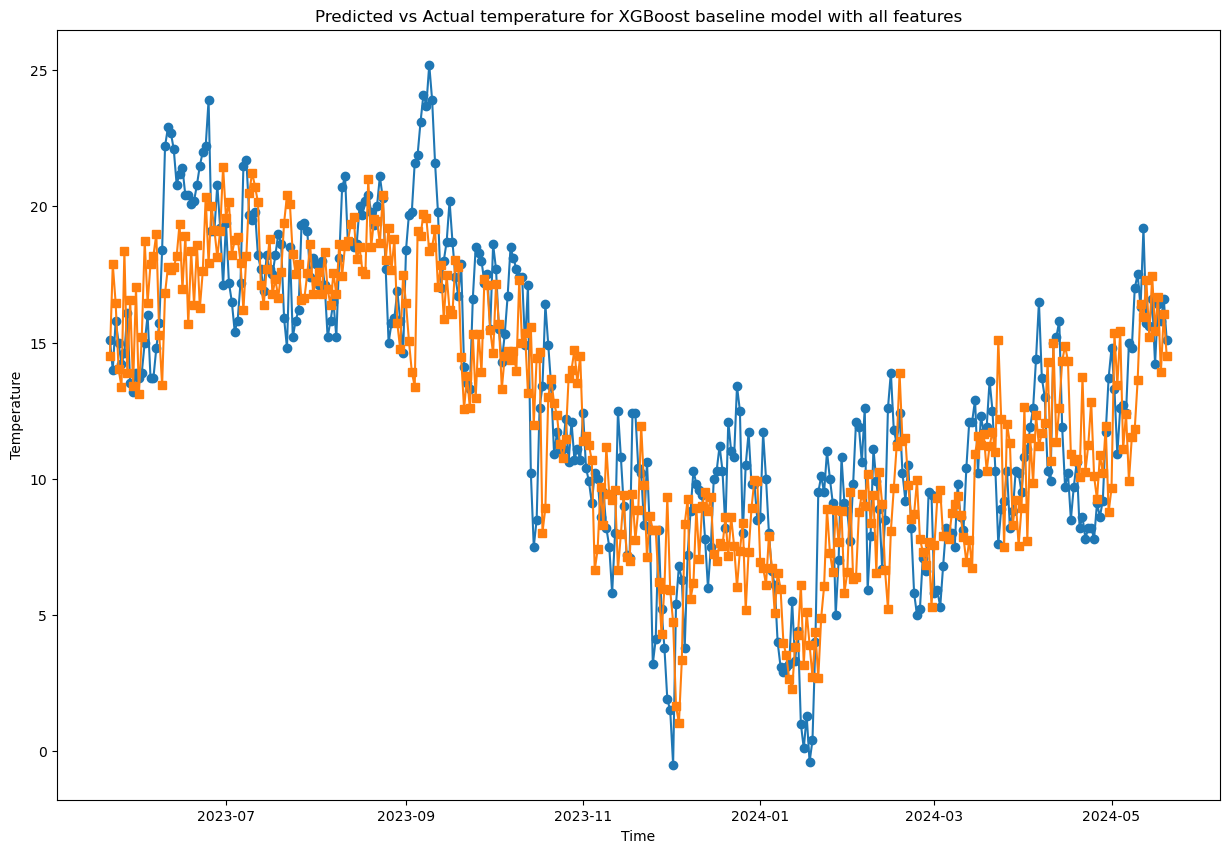

In [75]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['preds']])

### 1.4 Feature importance

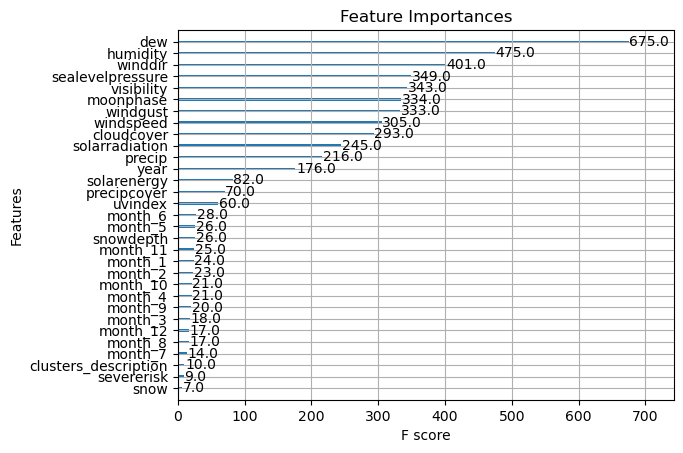

In [76]:
plot_importance(model_baseline)
plt.title('Feature Importances')
plt.show()

In [77]:
# look into dew and the importance of it in terms of climate change and weather prediction 
# the year has quite an important impact as it shows that the average temp is changing every year and therefore has an impact on all predictions
# it proves the temperature changes every year, and it is not cyclical 
# try removing all below 30 

In [78]:
future_preds = model_baseline.predict(df_future.drop('temp', axis=1))

In [79]:
df_future['preds'] = future_preds

In [80]:
df_future

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,preds
2024-05-21,NaN,10.5,69.7,0.797,100.0,8.33,0.0,0.0,25.0,15.2,147.1,1004.2,52.3,19.4,118.8,10.3,9.0,10.0,0.25,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,13.906611
2024-05-22,NaN,12.4,89.1,10.126,100.0,20.83,0.0,0.0,18.4,10.1,213.9,1005.2,58.3,15.8,74.5,6.5,3.0,10.0,0.27,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,16.043221
2024-05-23,NaN,10.3,70.2,0.000,0.0,0.00,0.0,0.0,17.4,9.4,194.8,1009.3,41.4,21.7,177.8,15.5,10.0,10.0,0.30,1.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,14.519270


### 1.5 XGBOOST GS

In [81]:
df_train.head()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2014-01-04,8.0,6.7,84.8,11.857,100.0,16.67,0.0,0.0,72.4,38.4,190.5,993.1,67.4,14.2,6.9,0.5,0.0,10.0,0.00,0.0,2014,True,False,False,False,False,False,False,False,False,False,False,False
2014-01-05,6.0,6.0,81.0,5.394,100.0,12.50,0.0,0.0,51.8,29.8,216.2,993.4,47.4,26.7,38.3,3.3,2.0,10.0,0.03,0.0,2014,True,False,False,False,False,False,False,False,False,False,False,False
2014-01-06,11.6,5.1,76.8,6.030,100.0,16.67,0.0,0.0,77.4,33.5,218.4,994.5,52.8,17.9,30.3,2.8,2.0,10.0,0.07,0.0,2014,True,False,False,False,False,False,False,False,False,False,False,False
2014-01-07,10.7,5.2,82.4,5.239,100.0,16.67,0.0,0.0,62.1,29.2,206.0,993.6,67.6,22.0,17.4,1.4,1.0,10.0,0.10,0.0,2014,True,False,False,False,False,False,False,False,False,False,False,False
2014-01-08,9.6,3.9,85.9,0.201,100.0,8.33,0.0,0.0,55.6,30.4,192.5,1000.0,66.5,25.5,30.4,2.6,2.0,10.0,0.14,0.0,2014,True,False,False,False,False,False,False,False,False,False,False,False


In [82]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'max_leaf_nodes':  [0, 10, 20], 
    'reg_lambda': [0, 0.1, 1]
}

grid_search = GridSearchCV(estimator=model_baseline, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [83]:
grid_search.fit(df_train.drop('temp', axis=1), df_train['temp']) #first one is train without target, second one is just target

best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 3 folds for each of 243 candidates, totalling 729 fits


In [84]:
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 0, 'reg_lambda': 1, 'subsample': 0.7}
Best score: -7.226425704507559


In [85]:
gs_model = XGBRegressor(learning_rate= 0.1, max_depth= 3, subsample= 0.7, max_leaf_nodes=0, reg_lambda=1)
gs_model.fit(df_train.drop('temp',axis=1), df_train[['temp']])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaf_nodes=0,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [86]:
pred_gs_model = gs_model.predict(df_test.drop('temp',axis=1))

### 1.6 XGBOOST GS performance metrics

In [87]:
mae = mean_absolute_error(df_test['temp'], pred_gs_model)
mse = mean_squared_error(df_test['temp'], pred_gs_model)
rmse = mse ** 0.5
r2 = r2_score(df_test['temp'], pred_gs_model)

print(f"Mean Absolute Error (MAE) for GS model: {mae}")
print(f"Mean Squared Error (MSE) for GS model: {mse}")
print(f"Root Mean Squared Error (RMSE) for GS model: {rmse}")
print(f"R-squared (R2) for XGBoost baseline GS model: {r2}")

Mean Absolute Error (MAE) for GS model: 2.1030320937012976
Mean Squared Error (MSE) for GS model: 7.130397327265726
Root Mean Squared Error (RMSE) for GS model: 2.6702803836424605
R-squared (R2) for XGBoost baseline GS model: 0.7413009588309011


In [88]:
df_test_w_preds['preds_gs'] = pred_gs_model

In [89]:
def plot_forecast(actuals, predictions): 
    plt.plot(actuals, label='Actuals', marker='o')
    plt.plot(predictions, label='Preds', marker='s')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.title('Predicted vs Actual temperature for XGBoost grid search model')
    plt.show()

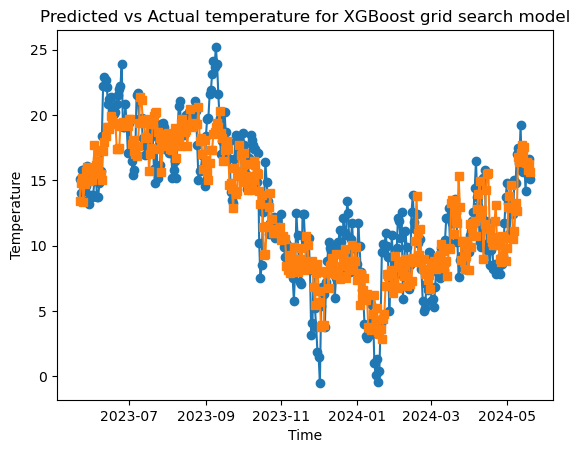

In [90]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['preds_gs']]) #rememer to not define the function again, just add in the new title when you call the function

## 2. Naive Forecaster (Sktime)

### 2.1 Baseline model

https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.naive.NaiveForecaster.html

In [91]:
forecaster_baseline = NaiveForecaster(strategy="mean")
forecaster_baseline.fit(df_train['temp'])

NaiveForecaster(strategy='mean')

In [92]:
preds_naive_baseline = forecaster_baseline.predict(df_test.index)

In [93]:
preds_naive_baseline

2023-05-22    12.189839
2023-05-23    12.189839
2023-05-24    12.189839
2023-05-25    12.189839
2023-05-26    12.189839
                ...    
2024-05-16    12.189839
2024-05-17    12.189839
2024-05-18    12.189839
2024-05-19    12.189839
2024-05-20    12.189839
Freq: D, Name: temp, Length: 365, dtype: float64

In [94]:
df_test_w_preds['sktime_naive'] = preds_naive_baseline

In [95]:
df_test_w_preds.head()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,preds,preds_gs,sktime_naive
2023-05-22,15.1,6.9,64.3,0.0,0.0,0.0,0.0,0.0,26.1,17.5,61.3,1027.2,55.6,27.2,99.0,8.7,4.0,10.0,0.00,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.492051,13.432552,12.189839
2023-05-23,14.0,6.1,60.6,0.0,0.0,0.0,0.0,0.0,36.4,21.3,40.6,1025.3,40.0,27.5,192.2,16.3,9.0,10.0,0.03,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,17.870735,14.786562,12.189839
2023-05-24,15.8,6.7,61.2,0.0,0.0,0.0,0.0,0.0,34.7,20.0,30.7,1021.7,43.9,35.0,156.4,13.6,7.0,10.0,0.06,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,16.441523,15.185232,12.189839
2023-05-25,15.0,6.7,57.9,0.0,0.0,0.0,0.0,0.0,41.5,23.9,12.1,1021.2,62.5,37.2,80.0,7.0,3.0,10.0,0.09,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.017682,13.373943,12.189839
2023-05-26,14.2,6.9,63.5,0.0,0.0,0.0,0.0,0.0,26.1,17.3,36.0,1026.5,27.0,29.2,147.4,12.5,7.0,10.0,0.12,0.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,13.380795,14.683416,12.189839


### 2.2 Naive Forecaster performance metrics

In [96]:
mae = mean_absolute_error(df_test['temp'], df_test_w_preds['sktime_naive'])
mse = mean_squared_error(df_test['temp'], df_test_w_preds['sktime_naive'])
rmse = np.sqrt(mse)
r2 = r2_score(df_test['temp'], df_test_w_preds['sktime_naive'])

print(f"Mean Absolute Error (MAE) for the Naive Forecaster: {mae}")
print(f"Mean Squared Error (MSE) for the Naive Forecaster: {mse}")
print(f"Root Mean Squared Error (RMSE) for the Naive Forecaster: {rmse}")
print(f"R-squared (R²) for the Naive Forecaster: {r2}")

Mean Absolute Error (MAE) for the Naive Forecaster: 4.4214064993500655
Mean Squared Error (MSE) for the Naive Forecaster: 28.21710502528725
Root Mean Squared Error (RMSE) for the Naive Forecaster: 5.311977506097635
R-squared (R²) for the Naive Forecaster: -0.023749123586186638


### 2.3 Naive Forecaster GS

In [97]:
# only one parameter to tune - strategy

In [98]:
def tune_naive(strategy): 
    forecaster_baseline = NaiveForecaster(strategy=strategy)
    forecaster_baseline.fit(df_train['temp'])
    preds_naive_baseline = forecaster_baseline.predict(df_test.index)
    df_test_w_preds['sktime_naive'] = preds_naive_baseline
    mae = mean_absolute_error(df_test['temp'], df_test_w_preds['sktime_naive'])

    mse = mean_squared_error(df_test['temp'], df_test_w_preds['sktime_naive'])
    rmse = np.sqrt(mse)
    r2 = r2_score(df_test['temp'], df_test_w_preds['sktime_naive'])

    print(f"{strategy}, Mean Absolute Error (MAE) for the Naive Forecaster: {mae}")
    print(f"{strategy}, Mean Squared Error (MSE) for the Naive Forecaster: {mse}")
    print(f"{strategy}, Root Mean Squared Error (RMSE) for the Naive Forecaster: {rmse}")
    print(f"{strategy}, R-squared (R²) for the Naive Forecaster: {r2}")

### 2.4. Naive Forecaster GS performance metrics

In [99]:
tune_naive("mean")

mean, Mean Absolute Error (MAE) for the Naive Forecaster: 4.4214064993500655
mean, Mean Squared Error (MSE) for the Naive Forecaster: 28.21710502528725
mean, Root Mean Squared Error (RMSE) for the Naive Forecaster: 5.311977506097635
mean, R-squared (R²) for the Naive Forecaster: -0.023749123586186638


In [100]:
tune_naive("last")

last, Mean Absolute Error (MAE) for the Naive Forecaster: 4.561643835616438
last, Mean Squared Error (MSE) for the Naive Forecaster: 29.52558904109589
last, Root Mean Squared Error (RMSE) for the Naive Forecaster: 5.433745397154333
last, R-squared (R²) for the Naive Forecaster: -0.07122243324038968


In [101]:
tune_naive("drift")

drift, Mean Absolute Error (MAE) for the Naive Forecaster: 4.736848034822686
drift, Mean Squared Error (MSE) for the Naive Forecaster: 31.844905375476948
drift, Root Mean Squared Error (RMSE) for the Naive Forecaster: 5.643129041186011
drift, R-squared (R²) for the Naive Forecaster: -0.15536990558079733


## 3. AUTO ARIMA

In [102]:
df_train_short = df_train[df_train.index > pd.to_datetime('2021-01-01')]

In [103]:
forecaster_arima = AutoARIMA(sp=12, suppress_warnings=True)
forecaster_arima.fit(df_train_short['temp'])

AutoARIMA(sp=12, suppress_warnings=True)

In [104]:
preds_autoarima = forecaster_arima.predict(df_test.index)

In [105]:
preds_autoarima

2023-05-22    13.984044
2023-05-23    13.895126
2023-05-24    13.759057
2023-05-25    13.725513
2023-05-26    13.632718
                ...    
2024-05-16    13.488740
2024-05-17    13.489218
2024-05-18    13.488746
2024-05-19    13.489213
2024-05-20    13.488752
Freq: D, Name: temp, Length: 365, dtype: float64

In [106]:
df_test_w_preds['preds_autoarima'] = preds_autoarima
df_test_w_preds

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,preds,preds_gs,sktime_naive,preds_autoarima
2023-05-22,15.1,6.9,64.3,0.000,0.0,0.00,0.0,0.0,26.1,17.5,61.3,1027.2,55.6,27.2,99.0,8.7,4.0,10.0,0.00,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.492051,13.432552,14.401869,13.984044
2023-05-23,14.0,6.1,60.6,0.000,0.0,0.00,0.0,0.0,36.4,21.3,40.6,1025.3,40.0,27.5,192.2,16.3,9.0,10.0,0.03,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,17.870735,14.786562,14.403738,13.895126
2023-05-24,15.8,6.7,61.2,0.000,0.0,0.00,0.0,0.0,34.7,20.0,30.7,1021.7,43.9,35.0,156.4,13.6,7.0,10.0,0.06,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,16.441523,15.185232,14.405607,13.759057
2023-05-25,15.0,6.7,57.9,0.000,0.0,0.00,0.0,0.0,41.5,23.9,12.1,1021.2,62.5,37.2,80.0,7.0,3.0,10.0,0.09,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.017682,13.373943,14.407477,13.725513
2023-05-26,14.2,6.9,63.5,0.000,0.0,0.00,0.0,0.0,26.1,17.3,36.0,1026.5,27.0,29.2,147.4,12.5,7.0,10.0,0.12,0.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,13.380795,14.683416,14.409346,13.632718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-16,14.2,11.0,73.4,0.000,0.0,0.00,0.0,0.0,35.2,21.0,183.4,1007.1,86.1,14.9,71.5,6.2,2.0,10.0,0.17,1.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,15.429116,16.348656,15.074766,13.488740
2024-05-17,16.4,11.7,77.8,3.598,100.0,33.33,0.0,0.0,30.5,21.0,149.7,1001.1,85.6,15.4,76.1,6.5,4.0,10.0,0.20,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,16.688347,16.409649,15.076636,13.489218
2024-05-18,15.8,10.5,69.7,0.797,100.0,8.33,0.0,0.0,25.0,15.2,147.1,1004.2,52.3,19.4,118.8,10.3,9.0,10.0,0.25,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,13.906611,15.812546,15.078505,13.488746
2024-05-19,16.6,12.4,89.1,10.126,100.0,20.83,0.0,0.0,18.4,10.1,213.9,1005.2,58.3,15.8,74.5,6.5,3.0,10.0,0.27,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,16.043221,16.279257,15.080374,13.489213


### 3.1 AUTO ARIMA performance metrics

In [107]:
mae = mean_absolute_error(df_test['temp'], df_test_w_preds['preds_autoarima'])
mse = mean_squared_error(df_test['temp'], df_test_w_preds['preds_autoarima'])
rmse = np.sqrt(mse)
r2 = r2_score(df_test['temp'], df_test_w_preds['preds_autoarima'])

print(f"Mean Absolute Error (MAE) for AUTO-ARIMA: {mae}")
print(f"Mean Squared Error (MSE) for AUTO-ARIMA: {mse}")
print(f"Root Mean Squared Error (RMSE) for AUTO-ARIMA: {rmse}")
print(f"R-squared (R²) for AUTO-ARIMA: {r2}") 

Mean Absolute Error (MAE) for AUTO-ARIMA: 4.44099364415425
Mean Squared Error (MSE) for AUTO-ARIMA: 27.790480289674576
Root Mean Squared Error (RMSE) for AUTO-ARIMA: 5.27166769530047
R-squared (R²) for AUTO-ARIMA: -0.008270685993376992


## 4. SARIMAX with all features (Sktime)

### 4.1 Baseline model 

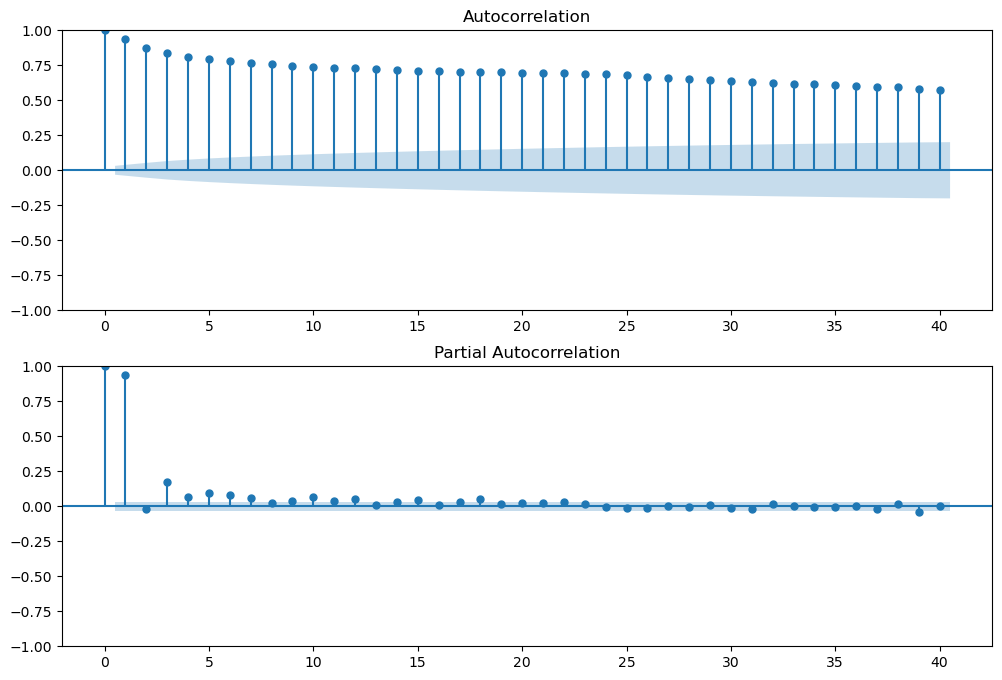

In [108]:
#ACF and PACF plots necessary to identify the p,d,q parameters

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_london['temp'], lags=40, ax=ax[0])
plot_pacf(df_london['temp'], lags=40, ax=ax[1])
plt.show()

In [109]:
# forecaster_sarimax = SARIMAX(order=(2, 0, 1), trend="t", seasonal_order=(1, 0, 0, 365))
# forecaster_sarimax.fit(df_train) 

In [110]:
# df_train_short.drop('temp',axis=1).astype(float)

In [111]:
# model_sarimax_baseline = StatsmodelsSARIMAX(
#     endog=df_train_short['temp'],
#     exog=df_train_short.drop('temp',axis=1).astype(float),
#     order=(1, 1, 1),  
#     seasonal_order=(1, 1, 1, 12)  
# )

In [112]:
# sarimax_base_results = model_sarimax_baseline.fit()

In [113]:
# forecast_sarimax = sarimax_base_results.get_forecast(steps=len(df_test), exog=df_test.drop('temp',axis=1).astype(float))

In [114]:
# forecast_sarimax.predicted_mean

In [115]:
# df_test_w_preds['preds_sarimax'] = forecast_sarimax.predicted_mean
# df_test_w_preds

### 4.2 SARIMAX baseline performance metrics

In [116]:
# mae = mean_absolute_error(df_test['temp'], df_test_w_preds['preds_sarimax'])
# mse = mean_squared_error(df_test['temp'], df_test_w_preds['preds_sarimax'])
# rmse = np.sqrt(mse)
# r2 = r2_score(df_test['temp'], df_test_w_preds['preds_sarimax'])

# print(f"Mean Absolute Error (MAE) for SARIMAX: {mae}")
# print(f"Mean Squared Error (MSE) for SARIMAX: {mse}")
# print(f"Root Mean Squared Error (RMSE) for SARIMAX: {rmse}")
# print(f"R-squared (R²) for SARIMAX: {r2}")

### 4.3 SARIMAX GS

In [117]:
# sarimax_results=df_test_w_preds.copy()

In [118]:
# def gridsearch_sarimax(p,d,q,P,D,Q,S,df_results_sarimax): 
#     print(p,d,q,P,D,Q,S)
#     model_sarimax_baseline = StatsmodelsSARIMAX(
#     endog=df_train_short['temp'],
#     exog=df_train_short.drop('temp',axis=1).astype(float),
#     order=(p,d,q),  
#     seasonal_order=(P,D,Q,S))
#     sarimax_base_results = model_sarimax_baseline.fit()
#     forecast_sarimax = sarimax_base_results.get_forecast(steps=len(df_test), exog=df_test.drop('temp',axis=1).astype(float))
#     df_results_sarimax[f"{p}_{d}_{q}_{P}_{D}_{Q}_{S}"]=forecast_sarimax.predicted_mean
#     return df_results_sarimax

In [119]:
# p_values = range(0, 2)
# d_values = [1]
# q_values = range(0, 2)
# P_values = range(0, 2)
# D_values = [1]
# Q_values = range(0, 2)
# s_values = [365]

In [120]:
# for p in p_values: 
#     for d in d_values:
#         for q in q_values: 
#             for P in P_values: 
#                 for D in D_values: 
#                     for Q in Q_values: 
#                         for s in s_values:
#                             sarimax_results = gridsearch_sarimax(p,d,q,P,D,Q,s,sarimax_results)

### 4.4 SARIMAX GS performance metrics

In [121]:
# add performance metrics

## 5. LSTM (Long Short Term Memory)

### 5.1 Baseline model 

In [122]:
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(df_london[['temp']])

In [123]:
#https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ 

def split_sequence(sequence, n_steps):
    xs, ys = [], []
    for i in range(len(sequence) - n_steps):
        x = sequence[i:i + n_steps]
        y = sequence[i + n_steps]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [124]:
n_steps = 30
X_train, y_train= split_sequence(values, n_steps)
X_test, y_test = split_sequence(values, n_steps)

In [125]:
#number of steps will be the lagged features of 3

In [126]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [127]:
y_test #this is the series we're trying to predict, try to create a 3D feature set 

array([[0.25970149],
       [0.31940299],
       [0.32238806],
       ...,
       [0.56716418],
       [0.59104478],
       [0.54626866]])

In [128]:
# Reshape data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [129]:
model_baseline = Sequential()
model_baseline.add(LSTM(50, return_sequences=True, input_shape=(n_steps, 1)))
model_baseline.add(LSTM(50))
model_baseline.add(Dense(1))
model_baseline.compile(optimizer='adam', loss='mean_squared_error')

In [130]:
model_baseline.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
118/118 [==============================] - 14s 42ms/step - loss: 0.0129 - val_loss: 0.0067
Epoch 2/10
118/118 [==============================] - 5s 40ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 3/10
118/118 [==============================] - 3s 29ms/step - loss: 0.0059 - val_loss: 0.0059
Epoch 4/10
118/118 [==============================] - 3s 25ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 5/10
118/118 [==============================] - 3s 24ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 6/10
118/118 [==============================] - 3s 25ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 7/10
118/118 [==============================] - 3s 24ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 8/10
118/118 [==============================] - 3s 25ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 9/10
118/118 [==============================] - 3s 25ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 10/10
118/118 [==============================] - 4s 30ms/step - loss: 0.0030 - val_l

In [131]:
def predict_future(model, data, n_steps, predict_n_days):
    prediction_list = data[-n_steps:].tolist()
    prediction_list = [item[0] for item in prediction_list]
    
    for _ in range(predict_n_days):
        x = np.array(prediction_list[-n_steps:]).reshape((1, n_steps, 1))
        out = model.predict(x)[0][0]
        prediction_list.append(out)

    # Transform the predictions back to the original scale
    prediction_list = scaler.inverse_transform(np.array(prediction_list).reshape(-1, 1))
    return prediction_list

In [132]:
predict_n_days = 365

In [133]:
yhat_baseline = predict_future(model_baseline, values, n_steps, predict_n_days)

1/1 [==============================] - 0s 31ms/step


In [134]:
yhat_baseline[n_steps:]

array([[14.4573537 ],
       [14.30124535],
       [14.2114792 ],
       [14.13125356],
       [14.07555206],
       [14.01231082],
       [13.9557667 ],
       [13.91143473],
       [13.86518587],
       [13.81409689],
       [13.76822342],
       [13.71899741],
       [13.66768878],
       [13.61822115],
       [13.56574841],
       [13.51375789],
       [13.4600192 ],
       [13.39928788],
       [13.3376071 ],
       [13.26880589],
       [13.19880463],
       [13.12816242],
       [13.04938442],
       [12.9795439 ],
       [12.91045815],
       [12.84281206],
       [12.77925334],
       [12.71528527],
       [12.64963295],
       [12.58437398],
       [12.52217505],
       [12.45928324],
       [12.40489361],
       [12.34943272],
       [12.29093877],
       [12.23422891],
       [12.18137279],
       [12.13325897],
       [12.0823427 ],
       [12.03251766],
       [11.97923124],
       [11.93010107],
       [11.88022811],
       [11.83092322],
       [11.78522048],
       [11

In [135]:
len(yhat_baseline[n_steps:])

365

In [136]:
df_test_w_preds['lstm_base'] = yhat_baseline[n_steps:]
df_test_w_preds

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,preds,preds_gs,sktime_naive,preds_autoarima,lstm_base
2023-05-22,15.1,6.9,64.3,0.000,0.0,0.00,0.0,0.0,26.1,17.5,61.3,1027.2,55.6,27.2,99.0,8.7,4.0,10.0,0.00,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.492051,13.432552,14.401869,13.984044,14.457354
2023-05-23,14.0,6.1,60.6,0.000,0.0,0.00,0.0,0.0,36.4,21.3,40.6,1025.3,40.0,27.5,192.2,16.3,9.0,10.0,0.03,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,17.870735,14.786562,14.403738,13.895126,14.301245
2023-05-24,15.8,6.7,61.2,0.000,0.0,0.00,0.0,0.0,34.7,20.0,30.7,1021.7,43.9,35.0,156.4,13.6,7.0,10.0,0.06,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,16.441523,15.185232,14.405607,13.759057,14.211479
2023-05-25,15.0,6.7,57.9,0.000,0.0,0.00,0.0,0.0,41.5,23.9,12.1,1021.2,62.5,37.2,80.0,7.0,3.0,10.0,0.09,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.017682,13.373943,14.407477,13.725513,14.131254
2023-05-26,14.2,6.9,63.5,0.000,0.0,0.00,0.0,0.0,26.1,17.3,36.0,1026.5,27.0,29.2,147.4,12.5,7.0,10.0,0.12,0.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,13.380795,14.683416,14.409346,13.632718,14.075552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-16,14.2,11.0,73.4,0.000,0.0,0.00,0.0,0.0,35.2,21.0,183.4,1007.1,86.1,14.9,71.5,6.2,2.0,10.0,0.17,1.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,15.429116,16.348656,15.074766,13.488740,9.033183
2024-05-17,16.4,11.7,77.8,3.598,100.0,33.33,0.0,0.0,30.5,21.0,149.7,1001.1,85.6,15.4,76.1,6.5,4.0,10.0,0.20,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,16.688347,16.409649,15.076636,13.489218,9.033183
2024-05-18,15.8,10.5,69.7,0.797,100.0,8.33,0.0,0.0,25.0,15.2,147.1,1004.2,52.3,19.4,118.8,10.3,9.0,10.0,0.25,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,13.906611,15.812546,15.078505,13.488746,9.033183
2024-05-19,16.6,12.4,89.1,10.126,100.0,20.83,0.0,0.0,18.4,10.1,213.9,1005.2,58.3,15.8,74.5,6.5,3.0,10.0,0.27,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,16.043221,16.279257,15.080374,13.489213,9.033183


In [137]:
# the model is very weak and it's predicting the same 200+ temperature. it needs improving with additiona layers

### 5.2 LSTM baseline performance metrics

In [138]:
# add performance metrics

### 5.3 Improved layers - LSTM

In [139]:
model_lstm_two = Sequential()
model_lstm_two.add(LSTM(100, return_sequences=True, input_shape=(n_steps, 1)))
model_lstm_two.add(Dropout(0.2))

model_lstm_two.add(LSTM(100, return_sequences=False))
model_lstm_two.add(Dropout(0.2))

model_lstm_two.add(Dense(50, activation='relu'))

model_lstm_two.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model_lstm_two.compile(optimizer=optimizer, loss='mean_squared_error')

history = model_lstm_two.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/3
118/118 [==============================] - 7s 34ms/step - loss: 0.0146 - val_loss: 0.0070
Epoch 2/3
118/118 [==============================] - 3s 25ms/step - loss: 0.0076 - val_loss: 0.0065
Epoch 3/3
118/118 [==============================] - 3s 27ms/step - loss: 0.0070 - val_loss: 0.0057


In [140]:
yhat_lstm_two = predict_future(model_lstm_two, values, n_steps, predict_n_days)

1/1 [==============================] - 0s 25ms/step


In [141]:
df_test_w_preds['lstm_two_layers'] = yhat_lstm_two[n_steps:]
df_test_w_preds

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,preds,preds_gs,sktime_naive,preds_autoarima,lstm_base,lstm_two_layers
2023-05-22,15.1,6.9,64.3,0.000,0.0,0.00,0.0,0.0,26.1,17.5,61.3,1027.2,55.6,27.2,99.0,8.7,4.0,10.0,0.00,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.492051,13.432552,14.401869,13.984044,14.457354,15.982759
2023-05-23,14.0,6.1,60.6,0.000,0.0,0.00,0.0,0.0,36.4,21.3,40.6,1025.3,40.0,27.5,192.2,16.3,9.0,10.0,0.03,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,17.870735,14.786562,14.403738,13.895126,14.301245,15.983266
2023-05-24,15.8,6.7,61.2,0.000,0.0,0.00,0.0,0.0,34.7,20.0,30.7,1021.7,43.9,35.0,156.4,13.6,7.0,10.0,0.06,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,16.441523,15.185232,14.405607,13.759057,14.211479,16.005105
2023-05-25,15.0,6.7,57.9,0.000,0.0,0.00,0.0,0.0,41.5,23.9,12.1,1021.2,62.5,37.2,80.0,7.0,3.0,10.0,0.09,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.017682,13.373943,14.407477,13.725513,14.131254,16.037542
2023-05-26,14.2,6.9,63.5,0.000,0.0,0.00,0.0,0.0,26.1,17.3,36.0,1026.5,27.0,29.2,147.4,12.5,7.0,10.0,0.12,0.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,13.380795,14.683416,14.409346,13.632718,14.075552,16.076092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-16,14.2,11.0,73.4,0.000,0.0,0.00,0.0,0.0,35.2,21.0,183.4,1007.1,86.1,14.9,71.5,6.2,2.0,10.0,0.17,1.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,15.429116,16.348656,15.074766,13.488740,9.033183,41.065923
2024-05-17,16.4,11.7,77.8,3.598,100.0,33.33,0.0,0.0,30.5,21.0,149.7,1001.1,85.6,15.4,76.1,6.5,4.0,10.0,0.20,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,16.688347,16.409649,15.076636,13.489218,9.033183,41.233143
2024-05-18,15.8,10.5,69.7,0.797,100.0,8.33,0.0,0.0,25.0,15.2,147.1,1004.2,52.3,19.4,118.8,10.3,9.0,10.0,0.25,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,13.906611,15.812546,15.078505,13.488746,9.033183,41.401382
2024-05-19,16.6,12.4,89.1,10.126,100.0,20.83,0.0,0.0,18.4,10.1,213.9,1005.2,58.3,15.8,74.5,6.5,3.0,10.0,0.27,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,16.043221,16.279257,15.080374,13.489213,9.033183,41.570951


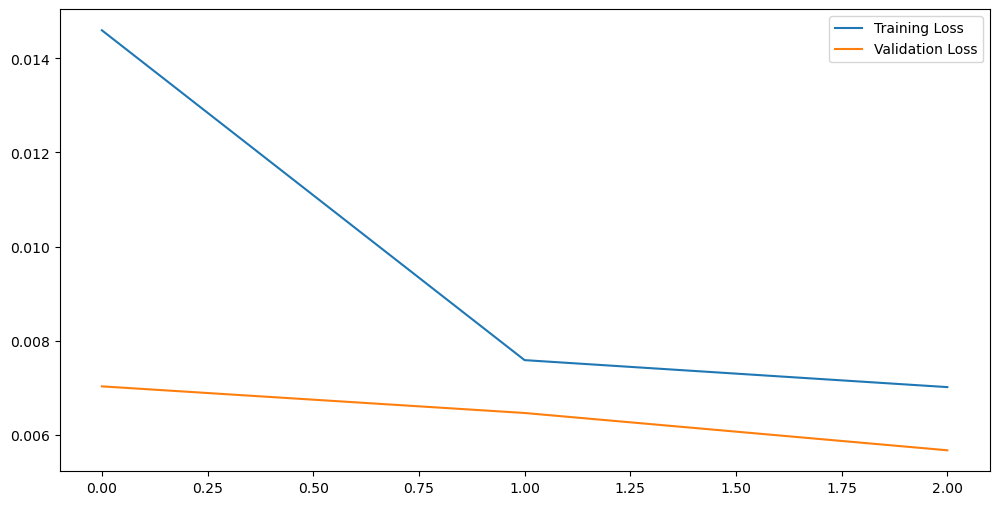

In [142]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

### 5.4 LSTM improved layers performance metrics

In [143]:
# add performance metrics

### 5.5 Tuning batch size for LSTM

In [144]:
history_batchsize_1 = model_lstm_two.fit(X_train, y_train, epochs=3, batch_size=1, validation_data=(X_test, y_test))


Epoch 1/3
3763/3763 [==============================] - 89s 24ms/step - loss: 0.0060 - val_loss: 0.0032
Epoch 2/3
3763/3763 [==============================] - 93s 25ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 3/3
3763/3763 [==============================] - 85s 23ms/step - loss: 0.0041 - val_loss: 0.0044


In [145]:
yhat_lstm_batch_1 = predict_future(model_lstm_two, values, n_steps, predict_n_days)


1/1 [==============================] - 0s 31ms/step


In [146]:
df_test_w_preds['lstm_two_layers_batch_size_1'] = yhat_lstm_batch_1[n_steps:]


In [147]:
df_test_w_preds

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,clusters_description,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,preds,preds_gs,sktime_naive,preds_autoarima,lstm_base,lstm_two_layers,lstm_two_layers_batch_size_1
2023-05-22,15.1,6.9,64.3,0.000,0.0,0.00,0.0,0.0,26.1,17.5,61.3,1027.2,55.6,27.2,99.0,8.7,4.0,10.0,0.00,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.492051,13.432552,14.401869,13.984044,14.457354,15.982759,16.350619
2023-05-23,14.0,6.1,60.6,0.000,0.0,0.00,0.0,0.0,36.4,21.3,40.6,1025.3,40.0,27.5,192.2,16.3,9.0,10.0,0.03,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,17.870735,14.786562,14.403738,13.895126,14.301245,15.983266,18.240752
2023-05-24,15.8,6.7,61.2,0.000,0.0,0.00,0.0,0.0,34.7,20.0,30.7,1021.7,43.9,35.0,156.4,13.6,7.0,10.0,0.06,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,16.441523,15.185232,14.405607,13.759057,14.211479,16.005105,19.419369
2023-05-25,15.0,6.7,57.9,0.000,0.0,0.00,0.0,0.0,41.5,23.9,12.1,1021.2,62.5,37.2,80.0,7.0,3.0,10.0,0.09,1.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,14.017682,13.373943,14.407477,13.725513,14.131254,16.037542,20.334003
2023-05-26,14.2,6.9,63.5,0.000,0.0,0.00,0.0,0.0,26.1,17.3,36.0,1026.5,27.0,29.2,147.4,12.5,7.0,10.0,0.12,0.0,2023,False,False,False,False,True,False,False,False,False,False,False,False,13.380795,14.683416,14.409346,13.632718,14.075552,16.076092,21.149556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-16,14.2,11.0,73.4,0.000,0.0,0.00,0.0,0.0,35.2,21.0,183.4,1007.1,86.1,14.9,71.5,6.2,2.0,10.0,0.17,1.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,15.429116,16.348656,15.074766,13.488740,9.033183,41.065923,26.900885
2024-05-17,16.4,11.7,77.8,3.598,100.0,33.33,0.0,0.0,30.5,21.0,149.7,1001.1,85.6,15.4,76.1,6.5,4.0,10.0,0.20,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,16.688347,16.409649,15.076636,13.489218,9.033183,41.233143,26.900885
2024-05-18,15.8,10.5,69.7,0.797,100.0,8.33,0.0,0.0,25.0,15.2,147.1,1004.2,52.3,19.4,118.8,10.3,9.0,10.0,0.25,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,13.906611,15.812546,15.078505,13.488746,9.033183,41.401382,26.900885
2024-05-19,16.6,12.4,89.1,10.126,100.0,20.83,0.0,0.0,18.4,10.1,213.9,1005.2,58.3,15.8,74.5,6.5,3.0,10.0,0.27,0.0,2024,False,False,False,False,True,False,False,False,False,False,False,False,16.043221,16.279257,15.080374,13.489213,9.033183,41.570951,26.900885


### 5.6. Batch size LSTM performance metrics

In [148]:
# add performance metrics

## Download of updated dataframe

In [149]:
# folder_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\data'
# file_name = 'london_weather_2014-2024_updated.csv'
# full_path = os.path.join(folder_path, file_name)

# # save the DataFrame to the specified path
# df_london.to_csv(full_path)

In [150]:
# pip freeze > requirements.txt